# Applications of Boltzmann generators - System 1: Double-well potential

## Section 1. Introduction: system of interest

To obtain a general sense about how Boltzmann generators work and how we can apply them to sample equilibrium states of many-body system, here we start with the simplest toy model, the double-well potential. Before we acquire the training data set, let's first visualize the double-well potential, which can be expressed as:
$$u({\bf x})=u(x_{1}, x_{2}) = ax_{1}^{4}-bx_{1}^{2}+cx_{1}+dx_{2}^{2}$$
To reproduce the data in the ["Boltzmann generator paper"](https://science.sciencemag.org/content/365/6457/eaaw1147) by Noe et al., we adopted $a=1,\;b=6, \; c=1, \;d=1 $. As the name suggests, the double-well potential has two energy minima, whose coordinates can be obtained by solving the following equations:
$$\frac{\partial u}{\partial x_{1}} = 4x^{3}-12x+1=0, \;\frac{\partial u}{\partial x_{2}}=x_{2}=0$$
As a result, the coordinates of the three stationary points are $(-1.7723, 0, -10.7524)$, $(0.08253, 0, 0.0417)$, and $(1.6888, 0, -7.2893)$, which are the global minimum, the saddle ppoint, and the local minimum, respectively.

To visualize the potential surface and check the positions of the minimum, we first import all the packages needed for this notebook and set the random seed to ensure reproducible results across different executions of the code.

In [1]:
import os
import sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import warnings
import torch 
from torch import distributions
from torch import nn
from torch.utils import data
from tqdm.auto import tqdm
from sklearn import datasets
warnings.filterwarnings('ignore')
sys.path.insert(1, '../')  # so the system can locate the library folder
sys.path.insert(1, '../Library')
import Library.potentials as potentials
import Library.generator as generator
import Library.sampling as sampling
import Library.training as training
import Library.visuals as visuals
import Library.density_estimator as density_estimator

In [2]:
seed = 2
np.random.seed(seed)
torch.manual_seed(seed)

The coordinates of the minima are: [-1.7723034076580755, 0.0] and [1.6887758209615107, 0.0].
The coordinate of the saddle point is: [0.08352758669656443, 0.0].
The energy difference between the two local minima is: 3.463.
The height of energy barrier is: 10.794.


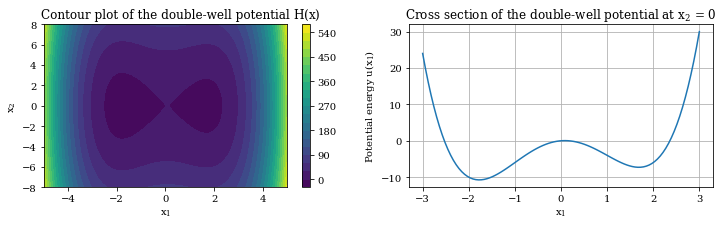

In [3]:
doublewell = potentials.DoubleWellPotential(a=1, b=6, c=1, d=1)  #  defaults = {"a": 1, "b": 6, "c": 1, "d": 1}
doublewell.plot_samples()  # another choice: a=0.25, b=1.5, c=1, d=1
print('The coordinates of the minima are: %s and %s.' % (list(doublewell.min_left), list(doublewell.min_right)))
print('The coordinate of the saddle point is: %s.' % list(doublewell.saddle))
print('The energy difference between the two local minima is: %5.3f.' % doublewell.e_diff)
print('The height of energy barrier is: %5.3f.' % doublewell.barrier)
plt.savefig('../Project/Pictures/DWP.png', dpi=600)

As shown above, there are two metastable states in the potential energy surface and the slow motion of crossing the energy barrier between them lies in th direction of $x_{1}$, given the fact that all three stationary points are all on the same line $x_{2}=0$. From the cross section of the potential at $x_{2}=0$, we can see that the minimum in the well on the left (state 1) has a smaller potental energy than the one in the right well (state 2). The energy difference between them is about 3.463 and the energy barrier (the difference between the global minimum and the saddle point) is 10.794.

The goals of applying a Boltzmann generator to this system include:
- Use a trained Boltzmann generator to generate configurations at both states.
- Use the Boltzmann generator to map out a possible reaction path between the two metastable states.
- Use the Boltzmann generator to compute the free energy as a function of the chosen reaction coordinate, which is $x_{1}$ in this case.
- Compute the free energy difference between the to metastable states.
- Assess the generator with differnt loss functions (ML, KL and ML+KL) in terms of accuracy.

## Section 2. Acquisition of the input dataset from Metropolis Monte Carlo simulations

As descried in our project paper, we have to extract samples from the configuration space ($x$ space, real space) to train the inverse generator network. To extract reasonable configurations, instead of randomly decide the coordinates of the configurations based on a Gaussian distribution, a better way is to run a Metropolis Monte Carlo simulation. Here, we use `sampling.MetropolisSampler` to run a Monte Carlo simulation for each minimum for 5000 steps. Since a Monte Carlo simulation is memoryless, each configuration are uncorrelated with each other. Combining the samples extracted from the two Monte Carlo simulation, we obtain a training data set of size 10002 samples (including the initial configurations) in the configuraiton sapce. Samples from different minimum are in different colors, as shown in the figure below. 

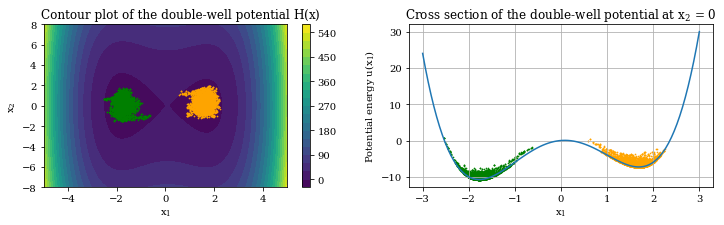

In [4]:
x_left = copy.deepcopy(doublewell.min_left)
x_right = copy.deepcopy(doublewell.min_right)

MCsampler1 = sampling.MetropolisSampler(doublewell)
MCsampler1.run(x_left, 5000)
samples1 = MCsampler1.xtraj

MCsampler2 = sampling.MetropolisSampler(doublewell)
MCsampler2.run(x_right, 5000)
samples2 = MCsampler2.xtraj

fig = doublewell.plot_samples(samples1)
fig = doublewell.plot_samples(samples2, fig, 'orange')
plt.savefig('../Project/Pictures/DWP_samples.png', dpi=600)

Another way to visualize the samples is to plot the distributions of the potential energy and the displacement in $x_{1}$ direction. As shown below, samples from State 1 and State 2 are colored in blue and red, respectively. From the histogram of potential energy, we can see that samples with a lower potential energy are dominant compared to samples with a higher potential energy. From the middle and the right panel, we can observe that the peaks of the distributions are also of minimal potential energies, which justify Monte Carlo simulations as a measure of extracting configurations in the $x$ space.

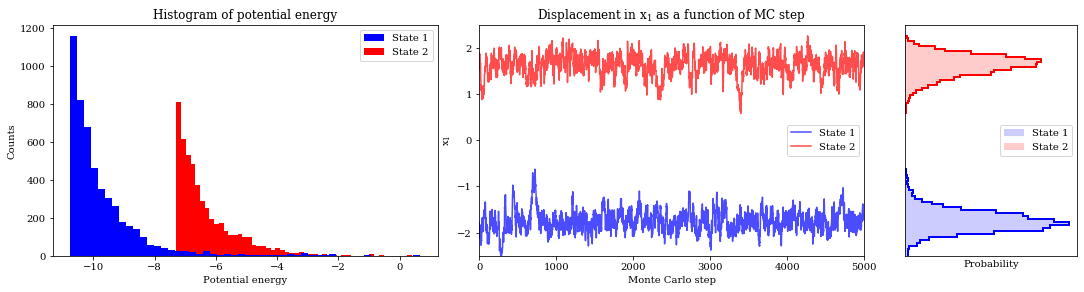

In [5]:
fig = plt.figure(figsize=(15, 4))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4), colspan=1)

ax1.hist(doublewell.get_energy([samples1[:, 0], samples1[:, 1]]), bins=50, color='blue', label='State 1', zorder=10)
ax1.hist(doublewell.get_energy([samples2[:, 0], samples2[:, 1]]), bins=50, color='red', label='State 2', zorder=0)
ax1.set_xlabel('Potential energy')
ax1.set_ylabel('Counts')
ax1.set_title('Histogram of potential energy')
ax1.legend()

ax2.plot(samples1[:, 0], color='blue', alpha=0.7, label='State 1')
ax2.plot(samples2[:, 0], color='red', alpha=0.7, label='State 2')
ax2.set_xlim(0, len(samples1))
ax2.set_ylim(-2.5, 2.5)
ax2.set_xlabel('Monte Carlo step')
ax2.set_ylabel('$ x_{1} $')
ax2.set_title('Displacement in $x_{1}$ as a function of MC step')
ax2.legend()

ax3.hist(samples1[:, 0], 30, orientation='horizontal', histtype='stepfilled', color='blue', alpha=0.2, label='State 1');
ax3.hist(samples1[:, 0], 30, orientation='horizontal', histtype='step', color='blue', linewidth=2);
ax3.hist(samples2[:, 0], 30, orientation='horizontal', histtype='stepfilled', color='red', alpha=0.2, label='State 2');
ax3.hist(samples2[:, 0], 30, orientation='horizontal', histtype='step', color='red', linewidth=2);
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_ylim(-2.5, 2.5)
ax3.set_xlabel('Probability')
ax3.legend()

fig.tight_layout(pad=0.5)
plt.savefig('../Project/Pictures/DWP_MC_histo.png', dpi=600)

Here, we combine the samples from different minimum into one training data set `x_samples` and shuffle the data.

In [6]:
x_samples = np.concatenate((samples1, samples2))  # the training dataset
np.random.shuffle(x_samples) # shuffle rows of data

## Section 3. The architecture of a Boltzmann generator

<center><img src=https://i.imgur.com/qgPKzrn.png width=600></center>
</br>

The architecture of a Boltzmann generator is shown in the figure above, which was reproduced from Figure 1. in the Boltzmann generator paper. To build a Boltzmann generator, we first have to specify the relevant parameters. Specifically, the Boltzmann generator applied to the double-well potential in this notebokk is composed of 3 NVP blocks, where there are two affine coupling layers for each block. An affine coupling layer performs affine transformation, i.e. shift-and-translating transformation. It is composed of two neural networks, one of which is for scaling (`s_net`) and the other is for translating (`t_net`). In our case here, both `s_net` and `t_net` are composed of three layers. In each neural network, there are 100 nodes for each layer and the activation functions include the ReLU function and the hyperbolic tangent function. In addition, we used Adam optimizer in the gradient descent method with the learning rate being 0.001. In the end, to train the Boltzmann generator, we include 1000 samples for each batch of the data and we set the iteration number as 200. Except for the number of iterations, we use the same set of parameters defined for all the cases explored in this notebook.

Practically, to build a Boltzmann generator, we first have to initialize `BoltzmannGenerator` in `training.py`. Then we use `build` method in `BoltzmannGenerator` to build the networks (`s_net` and `t_net`), define masking scheme for affined coupling layers (`mask`) and the prior distribution (`prior`) in the latent space (which is a Gaussian distribution). We these parameters (`s_net`, `t_net`, `mask`, `prior`) and  the system (double-well potential) defined, we are to initialize the class `RealNVP` and build a Boltzmann generator.

Below are some notes about the some of the argument to initialize `RealNVP`:
- **Scaling and translation neural networksin the coupling layers** (`s_net` and `t_net`):
    - `torch.nn.Sequential`: A sequential container. Modules will be added to it in the order they are passed in the constructor. Alternatively, an ordered dict of modules can also be passed in.
    - In our case here, all the layers are initialized by `nn.Linear` module, which applies a linear transofmration to the incoming data: $y = x A^{T} + b$. (Note that `nn.Linear` module automatically initializes the weights randomly.)
    - The dimensions of the input and the output of the networks should be 2, which correspond to the dimensionality of the proability distribution. Therefore, the number of input nodes of the first layer and the output node of the last layer are both 2.
    - For `s_net`, except that the last hidden layer uses hyperbolic tangent, other layers all use ReLU as the activation function. However, for `t_net`, there is no activation function for the last layer.
    - In `__init__` function of `RealNVP`, we use `nn.ModuleList`, which is like a Python list used to store a desired number of `nn.Module`’s as `self.t = torch.nn.ModuleList([t_net for _ in range(len(mask))])`. 
- **Masking shceme for affine coupling layers** (`mask`):
    - `masks = torch.from_numpy(np.array([[0, 1], [1, 0]] * n_blocks).astype(np.float32))`
    - In `__init__` function of `RealNVP` in `generator.py`, `self.mask = nn.Parameter(mask)` makes the mask as the module parameter. Note that `nn.Parameter` only takes in `torch.Tensor`. (Try printing `nn.Parameter(mask)`.)
- **Prior probability distribution in the latent space** (`prior`):
    - ``prior = distributions.MultivariateNormal(torch.zeros(dimension), torch.eye(dimension)``
    - Note that our double-well potential is a 2D function, so the Gaussian distribution must be bivariate. (`dimension=2`)
    - `torch.zeros(2)`: The mean of the bivariate normal distribution, which is a 1-by-2 zero matrix in this case.
    - `torch.eye(2)`: The covariance matrix of the bivariate normal distribution, which is an 2-by-2 identity matrix.
    - To generate 500 samples from the prior distribution, use `prior.sample_n(500)`.

## Section 4. Applying Boltzmann generators to double-well potential 

### Section 4-1. Boltzmann generators trained on maximum likelihood loss (ML loss)
According to Figure 1. in the Boltzmann generator paper, the steps of generating a sample in the configuration space using a Boltzmann generator are:
- **Step 1**: Generate samples from the probability distribution in the configuration space. (Done in Monte Carlo simulation in Section 2.)
- **Step 2**: Use the samples obtained in Step 1. to train the inverse generator $F_{xz}$ (or $G^{-1}$). (`inverse_generator` in `RealNVP`).
- **Step 3**: After the inverse generator is trained, generate samples from the prior distribution in the latent space.
- **Step 4**: Use the samples obtained in Step 3 as the input to the generator $F_{zx}$ (or $G$). (`generator` in `RealNVP`)

To get started, in this section, we will train the Boltzmann generator on the mximum likelihood loss (ML loss), i.e. train by the examples in the configuration space, as shown in the next cell.

Loading the trained ML model ...
Total loss: -0.3529486358165741


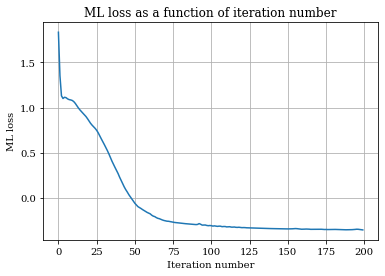

In [7]:
seed = 2
np.random.seed(seed)
torch.manual_seed(seed)

params_ML = {"n_blocks": 3, "dimension": 2, "n_nodes": 100, "n_layers": 3,
               "n_iterations": 200, "batch_size": 1000, "LR": 0.001, "prior_sigma": 1}
w_loss = [1, 0, 0]

BoltzmannGenerator_ML = training.BoltzmannGenerator(model_params=params_ML)
model_ML = BoltzmannGenerator_ML.build(doublewell)
if os.path.isfile('Trained_models/DoubleWell/model_ML') is True:  
    print("Loading the trained ML model ...")
    model_ML, loss = BoltzmannGenerator_ML.load(model_ML, 'Trained_models/DoubleWell/model_ML')
else:   
    print("Training model_ML ...")
    BoltzmannGenerator_ML.train(model_ML, w_loss, x_samples=x_samples)
    BoltzmannGenerator_ML.save(model_ML, 'Trained_models/DoubleWell/model_ML')
    loss = BoltzmannGenerator_ML.loss_list
    
# plot the loss function as a function of iteration
plt.figure()
plt.plot(range(len(loss)), loss)
plt.xlabel('Iteration number')
plt.ylabel('ML loss')
plt.title('ML loss as a function of iteration number')
plt.grid()
plt.savefig('../Project/Pictures/DWP_training_ML_loss.png', dpi=600)

As shown above, 

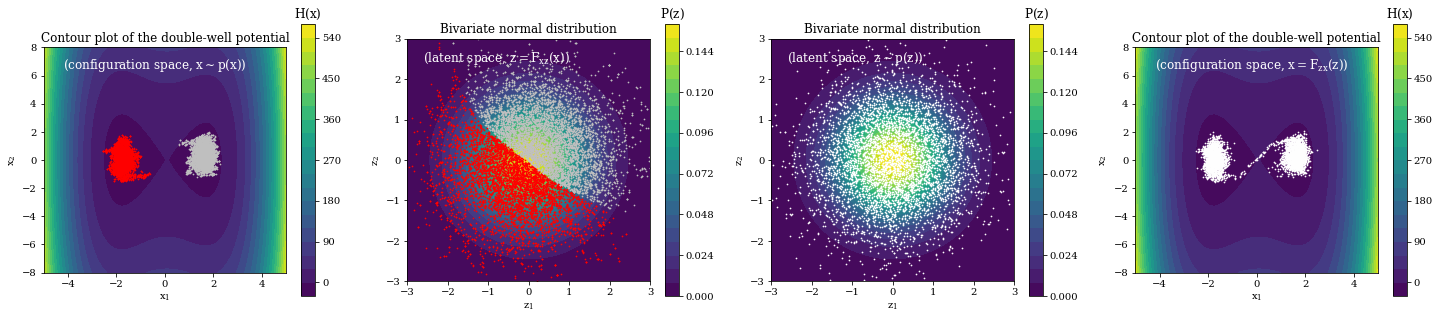

In [8]:
BoltzmannPlotter_ML = visuals.BoltzmannPlotter(doublewell, model_ML, [samples1, samples2])
BoltzmannPlotter_ML.generator_result('../Project/Pictures/DWP_ML_result.png')

As shown above,

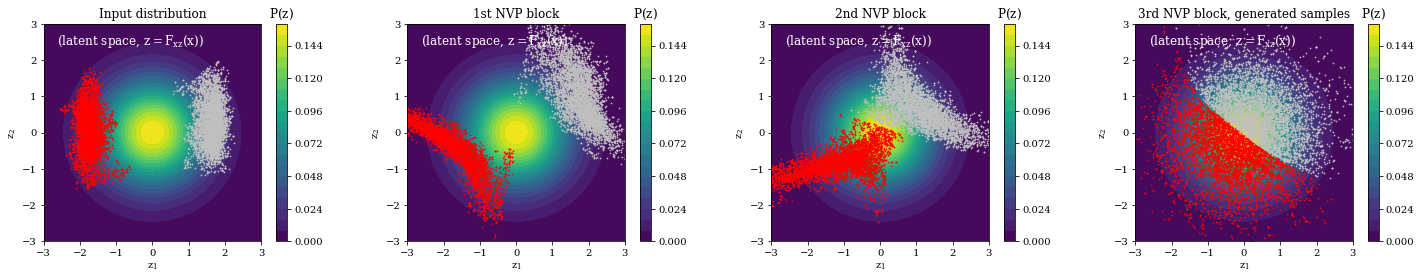

In [9]:
BoltzmannPlotter_ML.map_to_latent('../Project/Pictures/DWP_ML_to_latent_result.png')

As shown above, 

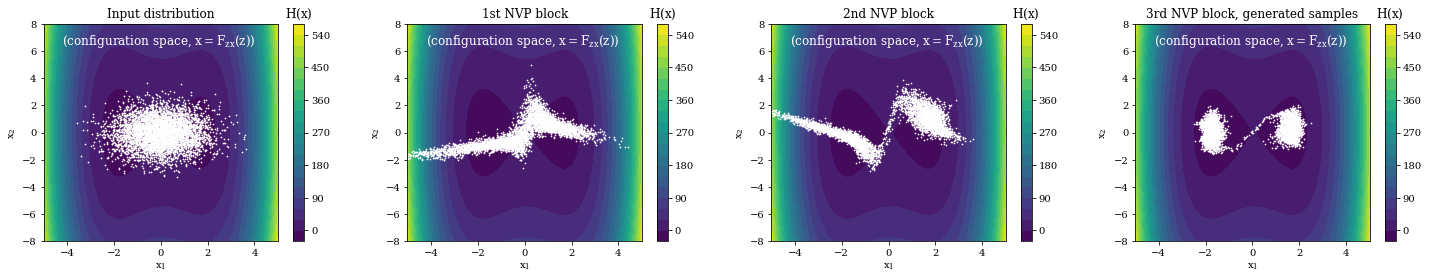

In [10]:
BoltzmannPlotter_ML.map_to_configuraiton('../Project/Pictures/DWP_ML_to_configuation_result.png')

As shown above,

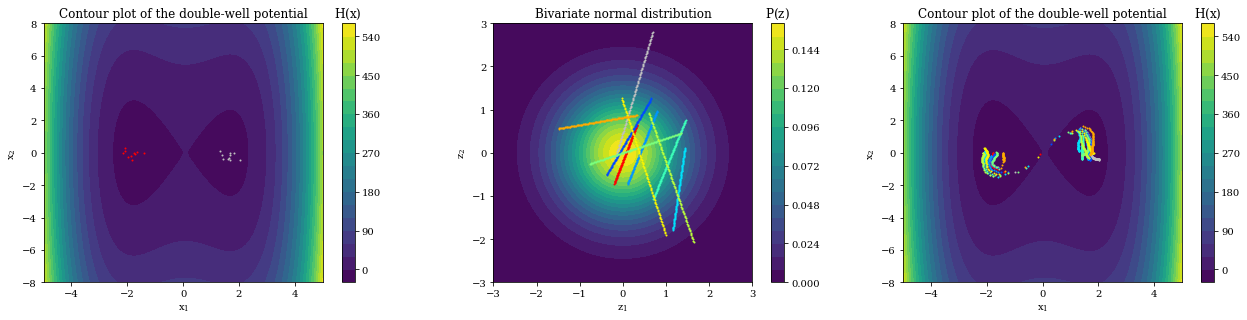

In [11]:
BoltzmannPlotter_ML.latent_interpolation('../Project/Pictures/DWP_ML_interpolation.png')

As shown above, 

### Section 4-2. Boltzmann generators trained on Kullback-Leibler loss (KL loss)

In this section, 

Loading the trained KL model ...
Total loss: -7.840846538543701


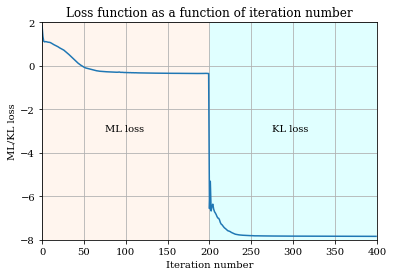

In [28]:
params_KL = {"n_blocks": 3, "dimension": 2, "n_nodes": 100, "n_layers": 3,
               "n_iterations": 200, "batch_size": 1000, "LR": 0.001, "prior_sigma": 1}
w_loss = [0, 1, 0]

BoltzmannGenerator_KL = training.BoltzmannGenerator(model_params=params_KL)
model_KL = BoltzmannGenerator_KL.build(doublewell)
if os.path.isfile('Trained_models/DoubleWell/model_KL') is True:  
    print("Loading the trained KL model ...")
    model_KL, loss = BoltzmannGenerator_KL.load(model_KL, 'Trained_models/DoubleWell/model_KL')
elif os.path.isfile('Trained_models/DoubleWell/model_ML') is True:
    print("Loading the trained ML model ...")
    model_KL, loss_ML = BoltzmannGenerator_KL.load(model_KL, 'Trained_models/DoubleWell/model_ML')
    print("Training the KL model based on the trained ML model ...")
    z_samples = BoltzmannGenerator_KL.prior.sample_n(10002).detach().numpy()  
    BoltzmannGenerator_KL.train(model_KL, w_loss, z_samples=z_samples)
    BoltzmannGenerator_KL.save(model_KL, 'Trained_models/DoubleWell/model_KL', previous_loss=loss_ML)
    loss = BoltzmannGenerator_KL.loss_list  # ML loss will be appended to KL loss automatically by specifying previos_loss
else:
    print("Error! No parameter files of ML or KL model found.") 
    print("(Note: The Boltzmann should be trained on the ML loss before it is trained on KL loss.)")
    sys.exit()
    
# plot the loss function as a function of iteration
plt.figure()
plt.plot(range(len(loss)), loss)
plt.xlabel('Iteration number')
plt.ylabel('ML/KL loss')
plt.title('Loss function as a function of iteration number')
plt.grid()
plt.savefig('../Project/Pictures/DWP_training_KL_loss.png', dpi=600)

y = np.arange(-20,10)
plt.fill_betweenx(y, 0, 200, color='seashell', zorder = 0)
plt.fill_betweenx(y, 200, 400, color='lightcyan', zorder = 0)
plt.text(75, -3, 'ML loss')
plt.text(275, -3, 'KL loss')
plt.xlim([0, 400])
plt.ylim([-8, 2])
plt.savefig('../Project/Pictures/DWP_training_KL_loss.png', dpi=600)

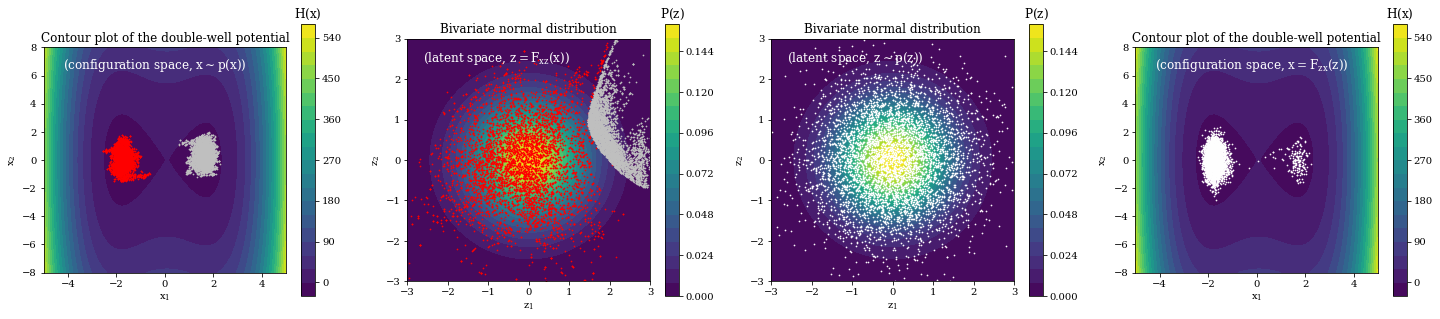

In [13]:
BoltzmannPlotter_KL = visuals.BoltzmannPlotter(doublewell, model_KL, [samples1, samples2])
BoltzmannPlotter_KL.generator_result('../Project/Pictures/DWP_KL_result.png')

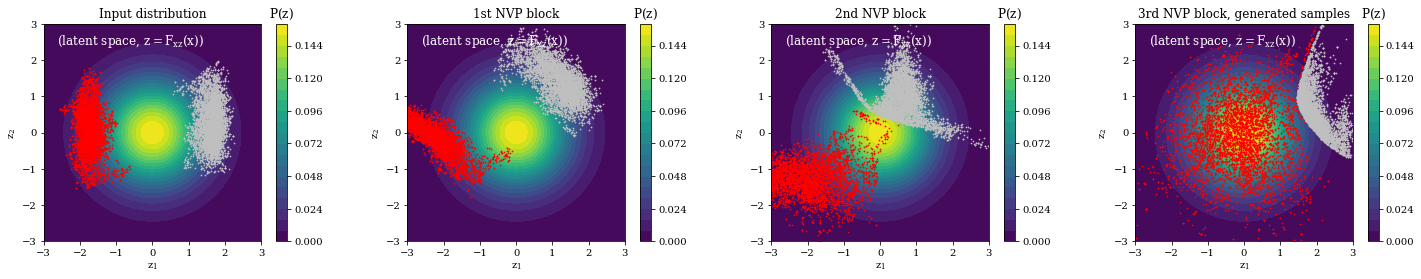

In [14]:
BoltzmannPlotter_KL.map_to_latent('../Project/Pictures/DWP_KL_to_latent_result.png')

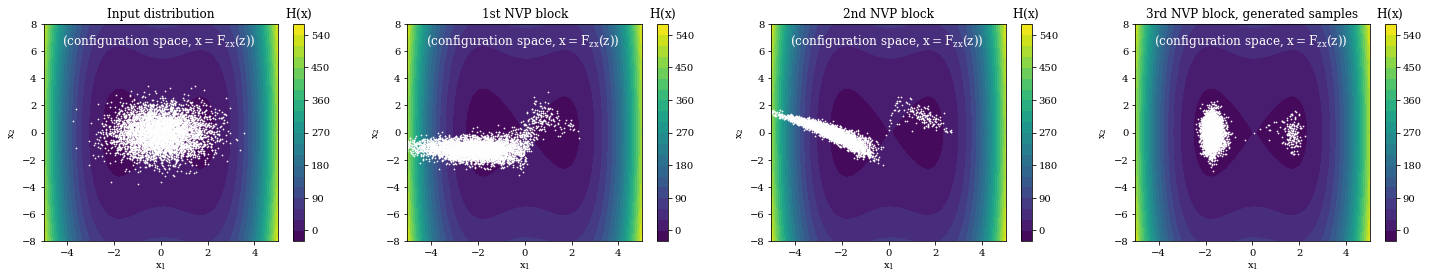

In [15]:
BoltzmannPlotter_KL.map_to_configuraiton('../Project/Pictures/DWP_KL_to_configuation_result.png')

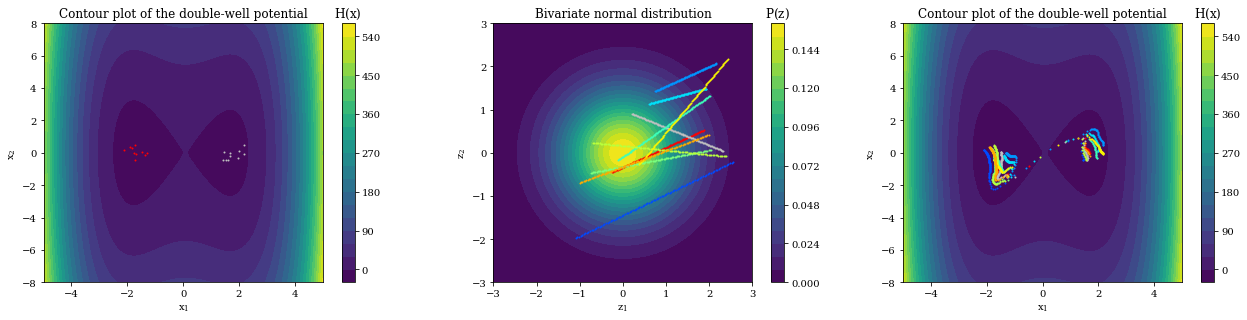

In [16]:
BoltzmannPlotter_KL.latent_interpolation('../Project/Pictures/DWP_KL_interpolation.png')

As shown above, the ML loss reach equilibration after about 80 interaions, which indicates that the inverse generator is successfully trained. However, to make sure, we still have to look into the samples generated in the real/configuration space by the generator. 

### Section 4-3. Boltzmann generators trained on ML loss and KL loss at the same time

Loading the trained MLKL model ...
Total loss: -7.697628021240234


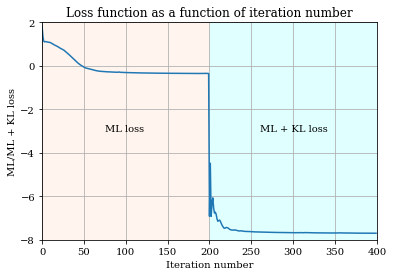

In [32]:
params_MLKL = {"n_blocks": 3, "dimension": 2, "n_nodes": 100, "n_layers": 3,
               "n_iterations": 200, "batch_size": 1000, "LR": 0.001, "prior_sigma": 1}
w_loss = [1, 1, 0]

BoltzmannGenerator_MLKL = training.BoltzmannGenerator(model_params=params_MLKL)
model_MLKL = BoltzmannGenerator_MLKL.build(doublewell)
if os.path.isfile('Trained_models/DoubleWell/model_MLKL') is True:  
    print("Loading the trained MLKL model ...")
    model_MLKL, loss = BoltzmannGenerator_MLKL.load(model_MLKL, 'Trained_models/DoubleWell/model_MLKL')
elif os.path.isfile('Trained_models/DoubleWell/model_ML') is True:
    print("Loading the trained ML model ...")
    model_MLKL, loss_ML = BoltzmannGenerator_MLKL.load(model_MLKL, 'Trained_models/DoubleWell/model_ML')
    print("Training the MLKL model based on the trained ML model ...")
    BoltzmannGenerator_MLKL.train(model_MLKL, w_loss, x_samples=x_samples, z_samples=z_samples)
    BoltzmannGenerator_MLKL.save(model_MLKL, 'Trained_models/DoubleWell/model_MLKL', previous_loss=loss_ML)
    loss = BoltzmannGenerator_MLKL.loss_list # ML loss will be appended to KL loss automatically by specifying previos_loss
        
# plot the loss function as a function of iteration
plt.figure()
plt.plot(range(len(loss)), loss)
plt.xlabel('Iteration number')
plt.ylabel('ML/ML + KL loss')
plt.title('Loss function as a function of iteration number')
plt.grid()
plt.savefig('../Project/Pictures/DWP_training_MLKL_loss.png', dpi=600)

y = np.arange(-20,10)
plt.fill_betweenx(y, 0, 200, color='seashell', zorder = 0)
plt.fill_betweenx(y, 200, 400, color='lightcyan', zorder = 0)
plt.text(75, -3, 'ML loss')
plt.text(260, -3, 'ML + KL loss')
plt.xlim([0, 400])
plt.ylim([-8, 2])
plt.savefig('../Project/Pictures/DWP_training_MLKL_loss.png', dpi=600)

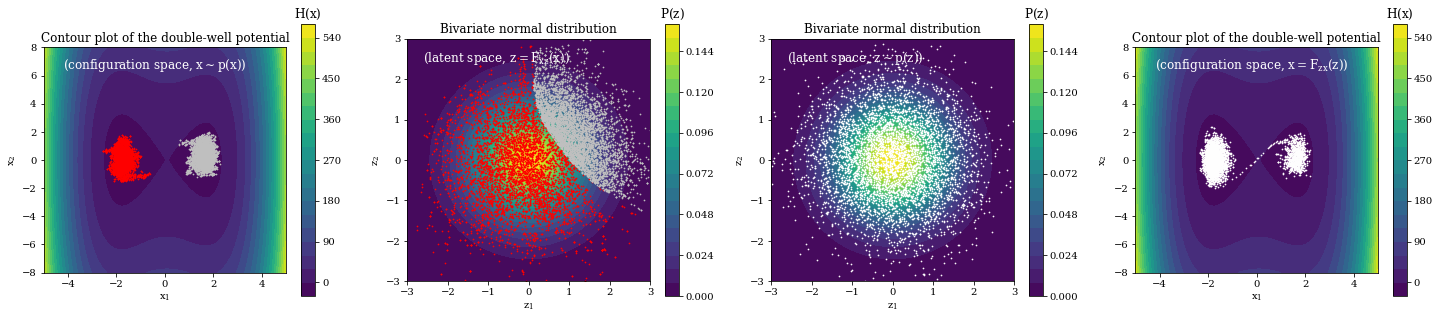

In [18]:
BoltzmannPlotter_MLKL = visuals.BoltzmannPlotter(doublewell, model_MLKL, [samples1, samples2])
BoltzmannPlotter_MLKL.generator_result('../Project/Pictures/DWP_MLKL_result.png')

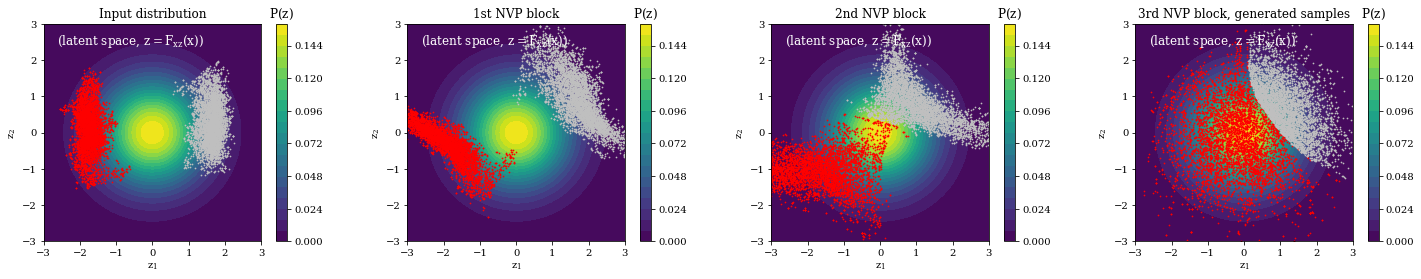

In [19]:
BoltzmannPlotter_MLKL.map_to_latent('../Project/Pictures/DWP_MLKL_to_latent_result.png')

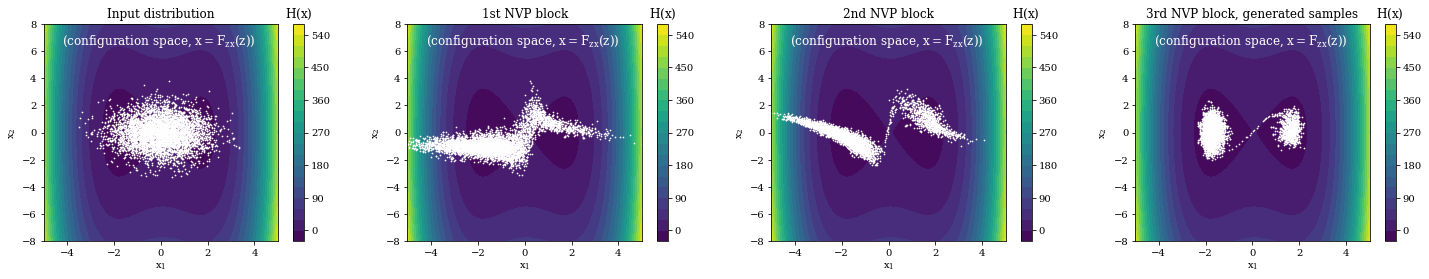

In [20]:
BoltzmannPlotter_MLKL.map_to_configuraiton('../Project/Pictures/DWP_MLKL_to_configuation_result.png')

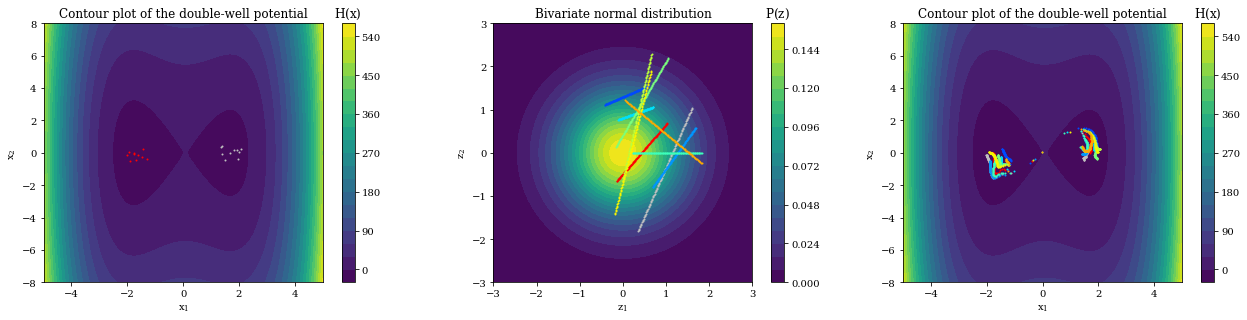

In [21]:
BoltzmannPlotter_MLKL.latent_interpolation('../Project/Pictures/DWP_MLKL_interpolation.png')

### Section 4-4. Introduction of the reaction coordinate loss (RC loss)

In [22]:
"""
params_RC = {"n_blocks": 3, "dimension": 2, "n_nodes": 100, "n_layers": 3,
               "n_iterations": 200, "batch_size": 1000, "LR": 0.001, "prior_sigma": 1}
w_loss = [1, 1, 1]

BoltzmannGenerator_MLKL = training.BoltzmannGenerator(model_params=params_MLKL)
model_MLKL = BoltzmannGenerator_MLKL.build(doublewell)
if os.path.isfile('Trained_models/DoubleWell/model_MLKL') is True:  
    print("Loading the trained MLKL model ...")
    model_MLKL, loss = BoltzmannGenerator_MLKL.load(model_MLKL, 'Trained_models/DoubleWell/model_MLKL')
elif os.path.isfile('Trained_models/DoubleWell/model_ML') is True:
    print("Loading the trained ML model ...")
    model_MLKL, loss_ML = BoltzmannGenerator_MLKL.load(model_MLKL, 'Trained_models/DoubleWell/model_ML')
    print("Training the MLKL model based on the trained ML model ...")
    BoltzmannGenerator_MLKL.train(model_MLKL, w_loss, x_samples=x_samples, z_samples=z_samples)
    BoltzmannGenerator_MLKL.save(model_MLKL, 'Trained_models/DoubleWell/model_MLKL')
    loss_MLKL = BoltzmannGenerator_MLKL.loss_list
    loss = loss_ML + loss_MLKL  # append the MLKL loss to the ML loss
        
# plot the loss function as a function of iteration
plt.figure()
plt.plot(range(len(loss)), loss)
plt.xlabel('Iteration number')
plt.ylabel('ML + KL loss')
plt.title('ML + KL loss as a function of iteration number')
plt.grid()
plt.savefig('../Project/Pictures/DWP_training_MLKL_loss.png', dpi=600)
"""

'\nparams_RC = {"n_blocks": 3, "dimension": 2, "n_nodes": 100, "n_layers": 3,\n               "n_iterations": 200, "batch_size": 1000, "LR": 0.001, "prior_sigma": 1}\nw_loss = [1, 1, 1]\n\nBoltzmannGenerator_MLKL = training.BoltzmannGenerator(model_params=params_MLKL)\nmodel_MLKL = BoltzmannGenerator_MLKL.build(doublewell)\nif os.path.isfile(\'Trained_models/DoubleWell/model_MLKL\') is True:  \n    print("Loading the trained MLKL model ...")\n    model_MLKL, loss = BoltzmannGenerator_MLKL.load(model_MLKL, \'Trained_models/DoubleWell/model_MLKL\')\nelif os.path.isfile(\'Trained_models/DoubleWell/model_ML\') is True:\n    print("Loading the trained ML model ...")\n    model_MLKL, loss_ML = BoltzmannGenerator_MLKL.load(model_MLKL, \'Trained_models/DoubleWell/model_ML\')\n    print("Training the MLKL model based on the trained ML model ...")\n    BoltzmannGenerator_MLKL.train(model_MLKL, w_loss, x_samples=x_samples, z_samples=z_samples)\n    BoltzmannGenerator_MLKL.save(model_MLKL, \'Train

## Section 5. Free energy calculations

After confirming that the Boltzmann generator we built was able to generate correct distributions, now we want use it to calculate free energy as a function of reaction coordinate, which is $x_{1}$ in this case. In this toy model, the potential energy is known, meaning that we can calculate the analytical free energy function.

Specifically, by definition, the reduced free energy as a function of a $x_{1}$, can be expressed as $f(x_{1})=-\ln Z(x_{1})$.
To calculate $Z(x_{1})$, we have to integrate the Boltzmann weights over the whole range of $x_{2}$:
$$Z(x_{1}) = \int e ^{-u(x_{1}, x_{2})} dx_{2} = \int^{\infty}_{-\infty} e^{-(x_{1}^{4} - 6x_{1}^{2} + x_{1} + x_{2}^{2})}dx_{2} = e^{-(x_{1}^{4} - 6x_{1}^{2} + x_{1})} \int ^{\infty}_{-\infty}e^{-x_{2}^{2}}dx_{2}=\sqrt{\pi} \cdot e^{-u({x_{1}})}$$
Where $u({x_{1}})=x_{1}^{4} - 6x_{1}^{2} + x_{1}$.

Therefore, $f=-\ln Z(x_{1}) = u(x_{1}) - \ln(\sqrt{\pi}) = x_{1}^{4} - 6x_{1}^{2} + x_{1} - \ln(\sqrt{\pi})$

In practice, to validate that the Boltzmann generator is able to perform free energy calculation, we follow the steps as shown below:
- **Step 1**: 


Specifically, the reduced free energy of the system can be calculated as:$f=-\ln p(x) + \text{constant}$, where $\text{constant}$ is actually $\ln Z_{x}$. Since we are only able to calculate energy differences rather than the absolute difference,  shifting the minimum of the free energy to 0 (so that the constant is 0) would give $f=\ln p(x)$. 

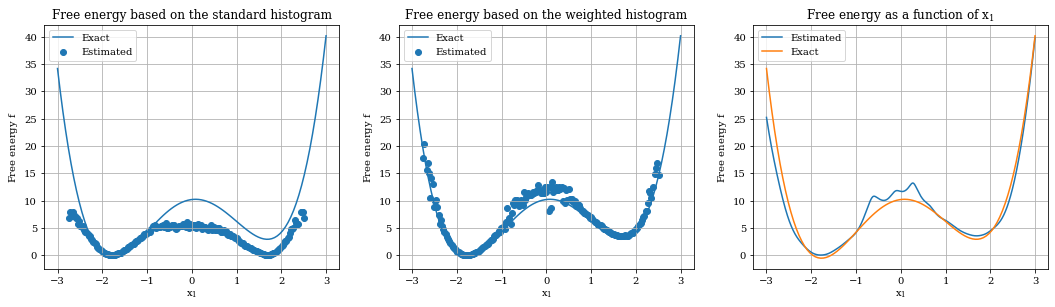

In [23]:
BoltzmannPlotter_ML.free_energy_profile('../Project/Pictures/DWP_free_energy_ML.png', 100000, 1000, True)

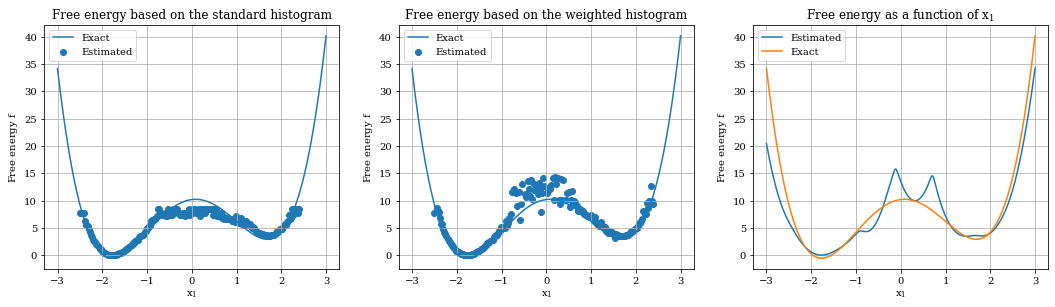

In [24]:
BoltzmannPlotter_KL.free_energy_profile('../Project/Pictures/DWP_free_energy_KL.png', 100000, 1000, True)

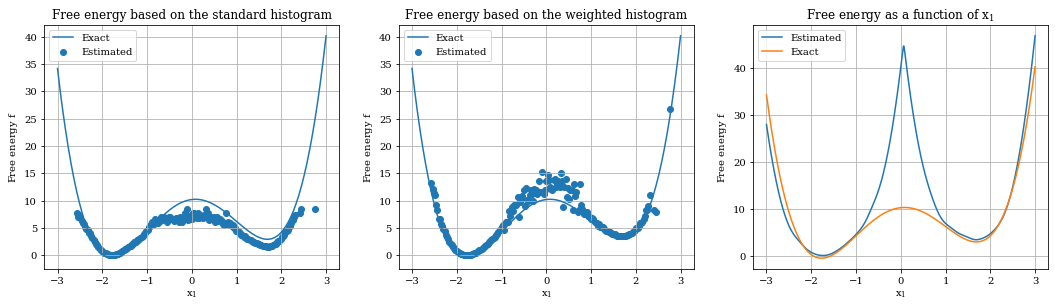

In [25]:
BoltzmannPlotter_MLKL.free_energy_profile('../Project/Pictures/DWP_free_energy_MLKL.png', 100000, 1000, True)

In [26]:
a

NameError: name 'a' is not defined

## ML model
### 1. Using weighted histogram

In [ ]:
z_f = prior.sample_n(100000)
x_f, log_R_zx = model_ML.generator((z_f))
x_f = x_f.detach().numpy()

In [ ]:
u_x = model_ML.calculate_energy(torch.from_numpy(x_f), space='configuration')
u_z = model_ML.calculate_energy(z_f, space='latent')
w = torch.exp(-u_x + u_z + log_R_zx)
w = w.detach().numpy()

In [ ]:
counts, bins = np.histogram(x_f[:, 0], bins=200)
probs = counts / np.sum(counts)  # p_x(x)
centers = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])  # x

f = -np.log(probs)
f -= np.min(f)

plt.figure()
plt.scatter(centers, f)
plt.xlabel("$x_{1}$")
plt.ylabel("Free energy $f$")
plt.title("Free energy as a function of $x_{1}$")
plt.grid()
#doublewell.plot_section(y=0)

x1  = np.linspace(-3, 3, 100)
f_analytical = doublewell.get_energy([x1, 0]) - np.log(np.sqrt(np.pi))
f_analytical -= doublewell.get_energy([-1.7723034076580755, 0.0])
plt.plot(x1, f_analytical)
plt.savefig('../Project/Pictures/DWP_free_energy_unweighted.png', dpi=600)

In [ ]:
counts, bins = np.histogram(x_f[:, 0], bins=200, weights=w)
probs = counts / np.sum(counts)  # p_x(x)
centers = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])  # x

f = -np.log(probs)
f -= np.min(f)

plt.figure()
plt.scatter(centers, f)
plt.xlabel("$x_{1}$")
plt.ylabel("Free energy $f$")
plt.title("Free energy as a function of $x_{1}$")
plt.grid()
#doublewell.plot_section(y=0)

x1  = np.linspace(-3, 3, 100)
f_analytical = doublewell.get_energy([x1, 0]) - np.log(np.sqrt(np.pi))
f_analytical -= doublewell.get_energy([-1.7723034076580755, 0.0])
plt.plot(x1, f_analytical)
plt.savefig('../Project/Pictures/DWP_free_energy_reweighted.png', dpi=600)

### 2. Using KDE

In [ ]:
from Library.density_estimator import density_estimator
z_f = prior.sample_n(1000)
x_f, log_R_zx = model_ML.generator((z_f))
x_f = x_f.detach().numpy()

u_x = model_ML.calculate_energy(torch.from_numpy(x_f), space='configuration')
u_z = model_ML.calculate_energy(z_f, space='latent')
w = torch.exp(-u_x + u_z + log_R_zx)
w = w.detach().numpy()

In [ ]:
x_range = np.linspace(-3, 3, len(x_f[:, 0] - 1))
p, log_p = density_estimator(x_f[:, 0], x_range, w, optimize=False)

In [ ]:
f = -log_p
f -= np.min(f)

plt.figure()
plt.plot(x_range, f)
plt.xlabel("$x_{1}$")
plt.ylabel("Free energy $f$")
plt.title("Free energy as a function of $x_{1}$")
plt.grid()
#doublewell.plot_section(y=0)

x1  = np.linspace(-3, 3, 100)
f_analytical = doublewell.get_energy([x1, 0]) - np.log(np.sqrt(np.pi))
f_analytical -= doublewell.get_energy([-1.7723034076580755, 0.0])
plt.plot(x1, f_analytical)

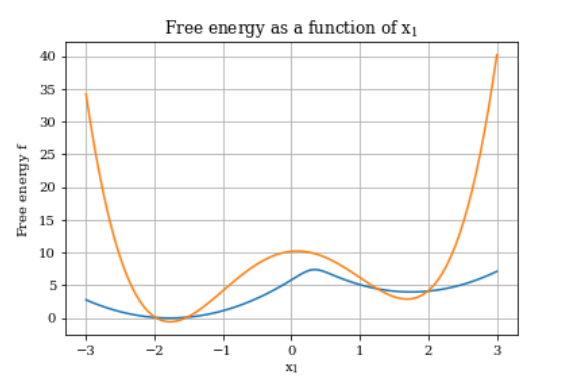

## KL model

In [ ]:
z_f = prior.sample_n(100000)
x_f, log_R_zx = model_KL.generator((z_f))
x_f = x_f.detach().numpy()

In [ ]:
u_x = model_KL.calculate_energy(torch.from_numpy(x_f), space='configuration')
u_z = model_KL.calculate_energy(z_f, space='latent')
w = torch.exp(-u_x + u_z + log_R_zx)
w = w.detach().numpy()

In [ ]:
counts, bins = np.histogram(x_f[:, 0], bins=200)
probs = counts / np.sum(counts)  # p_x(x)
centers = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])  # x

f = -np.log(probs)
f -= np.min(f)

plt.figure()
plt.scatter(centers, f)
plt.xlabel("$x_{1}$")
plt.ylabel("Free energy $f$")
plt.title("Free energy as a function of $x_{1}$")
plt.grid()
#doublewell.plot_section(y=0)

x1  = np.linspace(-3, 3, 100)
f_analytical = doublewell.get_energy([x1, 0]) - np.log(np.sqrt(np.pi))
f_analytical -= doublewell.get_energy([-1.7723034076580755, 0.0])
plt.plot(x1, f_analytical)
plt.savefig('../Project/Pictures/DWP_free_energy_KL_unweighted.png', dpi=600)

In [ ]:
counts, bins = np.histogram(x_f[:, 0], bins=200, weights=w)
probs = counts / np.sum(counts)  # p_x(x)
centers = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])  # x

f = -np.log(probs)
f -= np.min(f)

plt.figure()
plt.scatter(centers, f)
plt.xlabel("$x_{1}$")
plt.ylabel("Free energy $f$")
plt.title("Free energy as a function of $x_{1}$")
plt.grid()
#doublewell.plot_section(y=0)

x1  = np.linspace(-3, 3, 100)
f_analytical = doublewell.get_energy([x1, 0]) - np.log(np.sqrt(np.pi))
f_analytical -= doublewell.get_energy([-1.7723034076580755, 0.0])
plt.plot(x1, f_analytical)
plt.savefig('../Project/Pictures/DWP_free_energy_KL_reweighted.png', dpi=600)

## MLKL model

In [ ]:
z_f = prior.sample_n(100000)
x_f, log_R_zx = model_MLKL.generator((z_f))
x_f = x_f.detach().numpy()

In [ ]:
u_x = model_MLKL.calculate_energy(torch.from_numpy(x_f), space='configuration')
u_z = model_MLKL.calculate_energy(z_f, space='latent')
w = torch.exp(-u_x + u_z + log_R_zx)
w = w.detach().numpy()

In [ ]:
counts, bins = np.histogram(x_f[:, 0], bins=200)
probs = counts / np.sum(counts)  # p_x(x)
centers = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])  # x

f = -np.log(probs)
f -= np.min(f)

plt.figure()
plt.scatter(centers, f)
plt.xlabel("$x_{1}$")
plt.ylabel("Free energy $f$")
plt.title("Free energy as a function of $x_{1}$")
plt.grid()
#doublewell.plot_section(y=0)

x1  = np.linspace(-3, 3, 100)
f_analytical = doublewell.get_energy([x1, 0]) - np.log(np.sqrt(np.pi))
f_analytical -= doublewell.get_energy([-1.7723034076580755, 0.0])
plt.plot(x1, f_analytical)
plt.savefig('../Project/Pictures/DWP_free_energy_MLKL_unweighted.png', dpi=600)

In [ ]:
counts, bins = np.histogram(x_f[:, 0], bins=200, weights=w)
probs = counts / np.sum(counts)  # p_x(x)
centers = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])  # x

f = -np.log(probs)
f -= np.min(f)

plt.figure()
plt.scatter(centers, f)
plt.xlabel("$x_{1}$")
plt.ylabel("Free energy $f$")
plt.title("Free energy as a function of $x_{1}$")
plt.grid()
#doublewell.plot_section(y=0)

x1  = np.linspace(-3, 3, 100)
f_analytical = doublewell.get_energy([x1, 0]) - np.log(np.sqrt(np.pi))
f_analytical -= doublewell.get_energy([-1.7723034076580755, 0.0])
plt.plot(x1, f_analytical)
plt.savefig('../Project/Pictures/DWP_free_energy_MLKL_reweighted.png', dpi=600)

In [ ]:
from Library.density_estimator import density_estimator
z_f = prior.sample_n(100)
x_f, log_R_zx = model_ML.generator((z_f))
x_f = x_f.detach().numpy()

u_x = model_ML.calculate_energy(torch.from_numpy(x_f), space='configuration')
u_z = model_ML.calculate_energy(z_f, space='latent')
w = torch.exp(-u_x + u_z + log_R_zx)
w = w.detach().numpy()

In [ ]:
x_range = np.linspace(-3, 3, len(x_f[:, 0] - 1))
p, log_p = density_estimator(x_f[:, 0], x_range.reshape(-1, 1), w, optimize=True)

In [ ]:
f = -log_p
f -= np.min(f)

plt.figure()
plt.plot(x_range, f)
plt.xlabel("$x_{1}$")
plt.ylabel("Free energy $f$")
plt.title("Free energy as a function of $x_{1}$")
plt.grid()
#doublewell.plot_section(y=0)

x1  = np.linspace(-3, 0, 100)
f_analytical = doublewell.get_energy([x1, 0]) - np.log(np.sqrt(np.pi))
f_analytical -= doublewell.get_energy([-1.7723034076580755, 0.0])
plt.plot(x1, f_analytical)
plt.savefig('../Project/Pictures/DWP_free_energy_MLKL_reweighted.png', dpi=600)

In [ ]:
x_range = np.linspace(-3, 0, len(x_f[:, 0] - 1))
p, log_p = density_estimator(x_f[:, 0], x_range.reshape(-1, 1))

## Section 5.  Free energy calculations of double-well potential
With our model now correctly generating the Boltzmann distribution (bottom right), we can utilize it to calculate the free energy as a function of the reaction coordinate for this system (the coordinate $x_1$). The Boltzmann distribution is given by:
$p(x) = \exp(-f(x))$ so $f = -\log(p(x))$ where $f$ denote free energy. 

Steps:

1) Histogram the obtained samples to estimate probs

2) Filter probabilities to avoid single-sample, low-prob. states that are likely just noise

3) Calculate free energy

4) Shift free energy to lowest well reference state (we only get relative $f - f_0$)


Note: The smoothness of the average can be improved by generating more sample points.

Parameters to try
- Different masking schemes
- Different activation functions in each layer of the neural networks (s_net and t_net).
- Whether to use an activation function in the output layer.


## References